In [1]:
import random
from dataclasses import dataclass
from typing import Any, Dict, List, Union
from huggingface_hub import notebook_login
from datasets import load_dataset, DatasetDict, Audio, Dataset, concatenate_datasets
from transformers import WhisperFeatureExtractor, WhisperTokenizer, WhisperProcessor, WhisperForConditionalGeneration, Seq2SeqTrainingArguments, Seq2SeqTrainer, pipeline
import evaluate
import jiwer
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
import torch
import os
from tqdm import tqdm
import gradio as gr
import seaborn as sns
import time
import matplotlib.pyplot as plt

In [2]:
directory = "Prepared_Datasets"
all_dirs = os.listdir(directory)
test_batch_dirs = [f"{directory}/{dir_name}" for dir_name in all_dirs if dir_name.startswith('processed_test_batch')]
test_batch_datasets = [Dataset.load_from_disk(batch_dir) for batch_dir in test_batch_dirs]
test_dataset = concatenate_datasets(test_batch_datasets)

metric = evaluate.load("wer")
model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-tiny")
model.generation_config.language = "polish"
model.generation_config.task = "transcribe"
processor = WhisperProcessor.from_pretrained("openai/whisper-tiny")

def compute_metrics(pred):
    pred_ids = pred["predictions"]
    label_ids = pred["label_ids"]
    label_ids[label_ids == -100] = processor.tokenizer.pad_token_id

    pred_str = processor.tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    label_str = processor.tokenizer.batch_decode(label_ids, skip_special_tokens=True)

    pred_str = [p.lower() for p in pred_str]
    label_str = [l.lower() for l in label_str]

    wer = 100 * metric.compute(predictions=pred_str, references=label_str)
    return {"eval_wer": wer}



Transcribing Samples: 100%|██████████| 500/500 [04:04<00:00,  2.04sample/s]



WER Results:
openai/whisper-tiny: 79.36%
whisper-tiny-pl: 42.77%
whisper-tiny-pl03: 47.43%


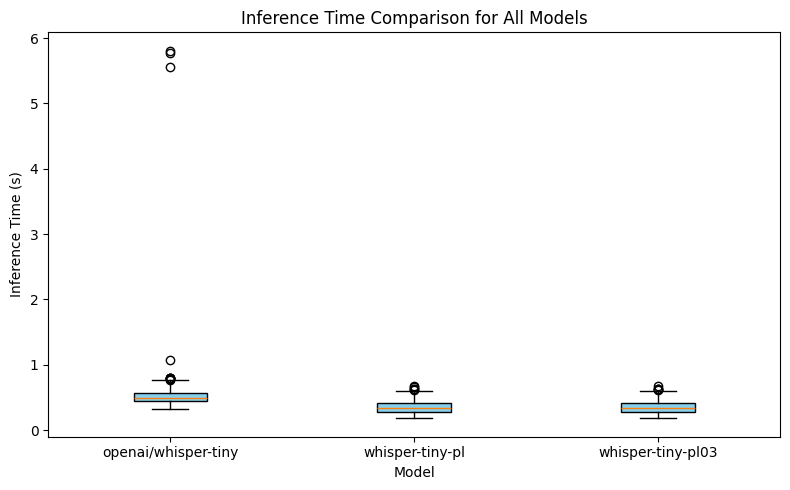

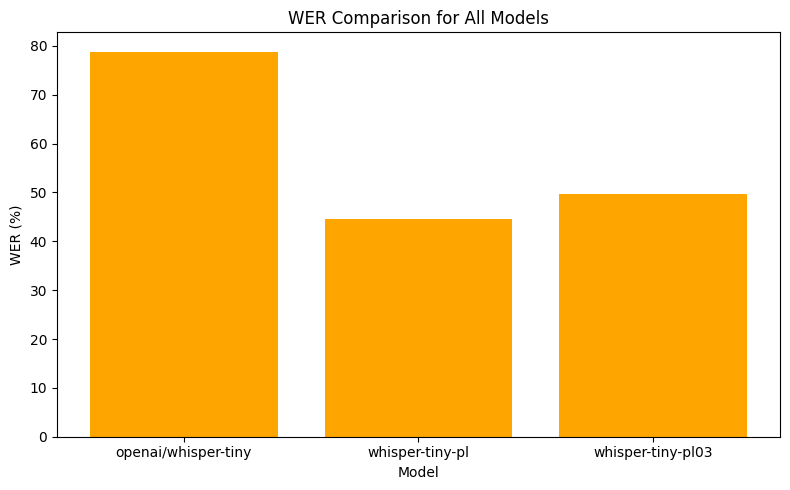

In [5]:
def get_random_samples(dataset, num_samples=100):
    random_indices = random.sample(range(len(dataset)), num_samples)
    return dataset.select(random_indices)

def transcribe_samples(model, processor, samples):
    results = []
    times = []
    predictions = []
    references = []
    wer_list = []

    for sample in tqdm(samples, desc="Transcribing Samples", unit="sample"):
        input_features = torch.tensor([sample["input_features"]])
        reference_str = processor.tokenizer.decode(sample["labels"], skip_special_tokens=True)

        attention_mask = torch.ones(input_features.shape[:2], dtype=torch.long)

        start_time = time.time()
        pred_ids = model.generate(input_features, attention_mask=attention_mask)
        pred_str = processor.tokenizer.batch_decode(pred_ids, skip_special_tokens=True)[0]
        end_time = time.time()

        predictions.append(pred_str)
        references.append(reference_str)
        times.append(end_time - start_time)

        pred = {
            "predictions": processor.tokenizer(pred_str, return_tensors="pt", padding=True, truncation=True).input_ids,
            "label_ids": processor.tokenizer(reference_str, return_tensors="pt", padding=True, truncation=True).input_ids,
        }
        metrics = compute_metrics(pred)
        wer_list.append(metrics["eval_wer"])

        results.append({"reference": reference_str, "transcription": pred_str})

    return results, times, wer_list, predictions, references

def evaluate_models(model_paths, samples, metric):
    results = {}
    times_all = {}
    wer_all = {}

    for model_path in model_paths:
        processor = WhisperProcessor.from_pretrained(model_path, language="pl", task="transcribe")
        model = WhisperForConditionalGeneration.from_pretrained(model_path)
        model.config.forced_decoder_ids = processor.tokenizer.convert_tokens_to_ids(["<|pl|>"])
        model.config.language = "pl"

        transcriptions, times, wer_list, predictions, references = transcribe_samples(model, processor, samples)

        overall_pred = {
            "predictions": processor.tokenizer(predictions, padding=True, truncation=True, return_tensors="pt").input_ids,
            "label_ids": processor.tokenizer(references, padding=True, truncation=True, return_tensors="pt").input_ids,
        }
        overall_metrics = compute_metrics(overall_pred)

        results[model_path] = overall_metrics["eval_wer"]
        times_all[model_path] = times
        wer_all[model_path] = wer_list

    return results, times_all, wer_all

def plot_inference_times_and_wer(times_all, wer_all):
    plt.figure(figsize=(8, 5))
    all_times = [times_all[model_path] for model_path in times_all]
    plt.boxplot(all_times, vert=True, patch_artist=True, boxprops=dict(facecolor="skyblue"))
    plt.title("Inference Time Comparison for All Models")
    plt.xlabel("Model")
    plt.ylabel("Inference Time (s)")
    plt.xticks(range(1, len(times_all) + 1), list(times_all.keys()))
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8, 5))
    wer_values = [wer_all[model_path] for model_path in wer_all]
    model_names = list(wer_all.keys())
    avg_wer = [sum(wer) / len(wer) for wer in wer_values]
    plt.bar(model_names, avg_wer, color='orange')
    plt.title("WER Comparison for All Models")
    plt.xlabel("Model")
    plt.ylabel("WER (%)")
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    model_folders = ["openai/whisper-tiny"]
    model_folders.extend(folder_name for folder_name in os.listdir() if folder_name.startswith("whisper"))
    num_samples = 500

    samples = get_random_samples(test_dataset, num_samples=num_samples)
    wer_results, times_results, wer_sample_results = evaluate_models(model_folders, samples, metric)

    print("\nWER Results:")
    for model, wer in wer_results.items():
        print(f"{model}: {wer:.2f}%")

    plot_inference_times_and_wer(times_results, wer_sample_results)

In [ ]:
## language tool

In [ ]:
import os
import time
import torchaudio
import pandas as pd
from transformers import WhisperProcessor, WhisperForConditionalGeneration
from tqdm import tqdm
import matplotlib.pyplot as plt
import evaluate
import language_tool_python

tool = language_tool_python.LanguageTool('pl')

def correct_polish_text(text):
    max_iterations = 3 
    for _ in range(max_iterations):
        matches = tool.check(text)
        if not matches:
            break
        corrected_parts = []
        last_pos = 0
        for match in matches:
            start = match.offset
            end = start + match.errorLength
            corrected_parts.append(text[last_pos:start])
            if match.replacements:
                corrected_parts.append(match.replacements[0])
            else:
                corrected_parts.append(text[start:end])
            last_pos = end
        corrected_parts.append(text[last_pos:])
        text = ''.join(corrected_parts)
    return text

metric = evaluate.load("wer")

def compute_metrics(pred, processor):
    pred_ids = pred["predictions"]
    label_ids = pred["label_ids"]
    label_ids[label_ids == -100] = processor.tokenizer.pad_token_id
    pred_str = processor.tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    label_str = processor.tokenizer.batch_decode(label_ids, skip_special_tokens=True)
    pred_str = [p.lower() for p in pred_str]
    label_str = [l.lower() for l in label_str]
    wer = 100 * metric.compute(predictions=pred_str, references=label_str)
    return {"eval_wer": wer}

def transcribe_samples(model, processor, samples, correct_text=False):
    results = []
    times = []
    predictions = []
    references = []
    wer_list = []

    for sample in tqdm(samples, desc=f"Transcribing Samples", unit="sample"):
        waveform, sample_rate = torchaudio.load(sample["file_path"])
        if sample_rate != processor.feature_extractor.sampling_rate:
            resampler = torchaudio.transforms.Resample(sample_rate, processor.feature_extractor.sampling_rate)
            waveform = resampler(waveform)
        input_features = processor(waveform.squeeze(0), sampling_rate=processor.feature_extractor.sampling_rate, return_tensors="pt").input_features

        reference_str = sample["reference"]

        start_time = time.time()
        pred_ids = model.generate(input_features)
        pred_str = processor.decode(pred_ids[0], skip_special_tokens=True)
        if correct_text:
            pred_str = correct_polish_text(pred_str)
        end_time = time.time()

        predictions.append(pred_str)
        references.append(reference_str)
        times.append(end_time - start_time)

        pred = {
            "predictions": processor.tokenizer(pred_str, return_tensors="pt", padding=True, truncation=True).input_ids,
            "label_ids": processor.tokenizer(reference_str, return_tensors="pt", padding=True, truncation=True).input_ids,
        }
        metrics = compute_metrics(pred, processor)
        wer_list.append(metrics["eval_wer"])

        results.append({"reference": reference_str, "transcription": pred_str})

    return results, times, wer_list, predictions, references

def evaluate_models(model_paths, samples, correct_text=False):
    results = {}
    times_all = {}
    wer_all = {}

    for model_path in model_paths:
        processor = WhisperProcessor.from_pretrained(model_path, language="pl", task="transcribe")
        model = WhisperForConditionalGeneration.from_pretrained(model_path)
        model.config.forced_decoder_ids = processor.get_decoder_prompt_ids(language="pl", task="transcribe")

        transcriptions, times, wer_list, predictions, references = transcribe_samples(model, processor, samples, correct_text)

        overall_pred = {
            "predictions": processor.tokenizer(predictions, padding=True, truncation=True, return_tensors="pt").input_ids,
            "label_ids": processor.tokenizer(references, padding=True, truncation=True, return_tensors="pt").input_ids,
        }
        overall_metrics = compute_metrics(overall_pred, processor)

        results[model_path] = overall_metrics["eval_wer"]
        times_all[model_path] = times
        wer_all[model_path] = wer_list

    return results, times_all, wer_all

def plot_wer_and_times(times_all_without, wer_all_without, times_all_with, wer_all_with):
    model_names = list(times_all_without.keys())
    
    fig_wer, axes_wer = plt.subplots(1, 2, figsize=(10, 6))
    
    wer_values_without = [wer_all_without[model_path] for model_path in model_names]
    avg_wer_without = [sum(wer) / len(wer) for wer in wer_values_without]
    bars_without = axes_wer[0].bar(model_names, avg_wer_without, color='orange')
    axes_wer[0].set_title("WER Without Correction")
    axes_wer[0].set_ylabel("WER (%)")
    axes_wer[0].tick_params(axis='x', rotation=45)
    for bar, wer in zip(bars_without, avg_wer_without):
        axes_wer[0].text(bar.get_x() + bar.get_width() / 2, wer / 2, f'{wer:.2f}%', 
                         ha='center', va='center', fontsize=10, color='white')
    
    wer_values_with = [wer_all_with[model_path] for model_path in model_names]
    avg_wer_with = [sum(wer) / len(wer) for wer in wer_values_with]
    bars_with = axes_wer[1].bar(model_names, avg_wer_with, color='green')
    axes_wer[1].set_title("WER With Correction")
    axes_wer[1].set_ylabel("WER (%)")
    axes_wer[1].tick_params(axis='x', rotation=45)
    for bar, wer in zip(bars_with, avg_wer_with):
        axes_wer[1].text(bar.get_x() + bar.get_width() / 2, wer / 2, f'{wer:.2f}%', 
                         ha='center', va='center', fontsize=10, color='white')
    
    plt.tight_layout()
    plt.show()
    
    fig_times, axes_times = plt.subplots(1, 2, figsize=(10, 6))
    
    all_times_without = [times_all_without[model_path] for model_path in model_names]
    axes_times[0].boxplot(all_times_without, labels=model_names, patch_artist=True, boxprops=dict(facecolor="skyblue"))
    axes_times[0].set_title("Inference Time Without Correction")
    axes_times[0].set_ylabel("Inference Time (s)")
    axes_times[0].tick_params(axis='x', rotation=45)
    
    all_times_with = [times_all_with[model_path] for model_path in model_names]
    axes_times[1].boxplot(all_times_with, labels=model_names, patch_artist=True, boxprops=dict(facecolor="lightcoral"))
    axes_times[1].set_title("Inference Time With Correction")
    axes_times[1].set_ylabel("Inference Time (s)")
    axes_times[1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()

audio_folder = "clips"
data = pd.read_csv("validated.tsv", sep="\t")
samples = []
for index, row in data.iterrows():
    file_path = os.path.join(audio_folder, row["path"])
    if os.path.exists(file_path):
        samples.append({"file_path": file_path, "reference": row["sentence"]})
        
model_folders = ["openai/whisper-tiny", "openai/whisper-base", "openai/whisper-small"]
model_folders.extend([folder_name for folder_name in os.listdir() if folder_name.startswith("whisper")])

results_without_correction, times_all_without_correction, wer_all_without_correction = evaluate_models(model_folders, samples, correct_text=False)

results_with_correction, times_all_with_correction, wer_all_with_correction = evaluate_models(model_folders, samples, correct_text=True)

plot_wer_and_times(times_all_without_correction, wer_all_without_correction, 
                   times_all_with_correction, wer_all_with_correction)